# Preliminary Analysis

This notebook focuses on exploring the given `consumer`, `merchant`, and `transaction` datasets. This aims to generate insights and engineer useful features to be used for future modelling.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
IN = Path("../data/cleaned")
CUR = Path("../data/curated")
CUR.mkdir(parents=True, exist_ok=True)

consumer_details = pd.read_parquet(IN / "consumer_details.parquet")
consumer_fraud = pd.read_parquet(IN / "consumer_fraud.parquet")

merchant_details = pd.read_parquet(IN / "merchant_details.parquet")
merchant_fraud = pd.read_parquet(IN / "merchant_fraud.parquet")

transactions = pd.read_parquet(IN / "transaction.parquet")

# Consumer Dataset

### Dataset Shapes

In [3]:
print("consumer_details shape:", consumer_details.shape)   
print("consumer_fraud shape:", consumer_fraud.shape)
print("transactions shape:", transactions.shape)

print("unique consumers in consumer_details:", consumer_details["user_id"].nunique())
print("unique consumers in consumer_fraud:", consumer_fraud["user_id"].nunique())
print("unique consumers in transactions:", transactions["user_id"].nunique())

consumer_details shape: (499999, 7)
consumer_fraud shape: (34864, 4)
transactions shape: (13614672, 5)
unique consumers in consumer_details: 499999
unique consumers in consumer_fraud: 20128
unique consumers in transactions: 24081


### Merge the consumer data

In [4]:
# Join consumer data
consumer_df = consumer_details.merge(consumer_fraud, on="consumer_id", how="left")

In [5]:
# Check how many consumer has a fraud probability record
n_total = consumer_df["consumer_id"].nunique()
n_with_fraud = consumer_df["tx_fraud_consumer"].notna().sum()   # if multiple rows per consumer
n_with_fraud_unique = consumer_df.groupby("consumer_id")["tx_fraud_consumer"].apply(lambda s: s.notna().any()).sum()

print("Total consumers:", n_total)
print("Consumers with ≥1 fraud probability record:", n_with_fraud_unique)
print("Coverage (%):", round(n_with_fraud_unique / n_total * 100, 2))

Total consumers: 499999
Consumers with ≥1 fraud probability record: 20128
Coverage (%): 4.03


In [6]:
consumer_df["tx_fraud_consumer"].describe()

count    34864.000000
mean         0.151201
std          0.099461
min          0.082871
25%          0.096344
50%          0.117356
75%          0.162162
max          0.992474
Name: tx_fraud_consumer, dtype: float64

## Consumer Feature Engineering

In [7]:
transactions.shape

(13614672, 5)

In [8]:
# Join consumer with transaction
tx_consumer = transactions.merge(consumer_details[["user_id","consumer_id"]].drop_duplicates(),
                   on="user_id", how="left")

tx_consumer.shape

(13614672, 6)

In [9]:
# Create consumer level features
consumer_ft = (tx_consumer.groupby("consumer_id")
    .agg(
        transaction_count=("order_id","nunique"),
        total_spend=("dollar_value","sum"),
        unique_merchants=("merchant_abn","nunique")
    )
    .reset_index()
)

consumer_ft["avg_spend"] = consumer_ft["total_spend"] / consumer_ft["transaction_count"]

fraud_agg = (consumer_df
    .sort_values(["consumer_id","order_datetime"])
    .groupby("consumer_id")
    .agg(
        fraud_prob_avg=("tx_fraud_consumer", "mean"),
    )
    .reset_index()
)

# Final merge
consumer_features = (consumer_ft
    .merge(fraud_agg, on="consumer_id", how="left")
    .merge(consumer_details, on="consumer_id", how="left")
)

consumer_features.head(10)


,consumer_id,transaction_count,total_spend,unique_merchants,avg_spend,fraud_prob_avg,name,address,state,postcode,gender,user_id
0,1000031,576,94976.245070,344,164.889314,0.246955,Pamela Olsen,024 Hood Summit Suite 983,NSW,2177,Female,12606
1,1000051,561,93671.439271,342,166.972263,0.097455,Calvin Scott,5027 Richard Lane Apt. 564,QLD,4053,Male,8622
2,1000067,552,72193.558355,344,130.785432,0.126411,Michelle Fox,6749 Peter Cape,WA,6623,Female,2917
3,1000092,577,88144.192996,339,152.762899,NaN,Chelsea Cook,5495 Jones Light,QLD,4850,Female,12179
4,1000115,583,85280.337277,355,146.278452,0.104338,Troy Hess,788 Kristopher Crest,WA,6030,Male,12071
5,100023,564,88589.900056,351,157.074291,0.096438,Mark Berry,6424 Jones Ford,WA,6914,Male,2320
6,1000286,566,79447.297497,326,140.366250,0.125641,Jason Johnson,455 Davis Union,SA,5280,Undisclosed,4030
7,1000293,569,83032.851154,331,145.927682,0.122220,Tara Espinoza,31738 James Lakes Apt. 236,VIC,3242,Female,5064
8,1000337,564,73255.985807,335,129.886500,0.098571,Jennifer Hughes,9751 Gene Street,NSW,1037,Female,13357
9,100039,554,103489.325538,333,186.803837,0.451171,Michelle Freeman,7592 Pierce Road Apt. 486,NSW,2118,Female,15692


In [10]:
consumer_features.shape

(24081, 12)

In [11]:
# count NaN values per column
nan_counts = consumer_features.isna().sum()
nan_counts

consumer_id             0
transaction_count       0
total_spend             0
unique_merchants        0
avg_spend               0
fraud_prob_avg       3953
name                    0
address                 0
state                   0
postcode                0
gender                  0
user_id                 0
dtype: int64

In [12]:
# Save to curated folder
consumer_features.to_parquet(CUR / "consumer_features.parquet", index=False)

**Notes:**
- From the table above, we can see that a consumer can have many transactions but only a few transaction has a fraud probability associated with it.
- Only 24,081 consumers had a transaction recorded out of 499,999 consumers in our original `consumer_details` dataset
- 3953 consumers does not have a fraud probability

## EDA for Consumer Dataset

In [13]:
consumer_features.describe(percentiles=[.25,.5,.75,.9,.95])

,transaction_count,total_spend,unique_merchants,avg_spend,fraud_prob_avg
count,24081.000000,24081.000000,24081.000000,24081.000000,20128.000000
mean,565.369877,89564.473333,338.587559,158.416677,0.156690
std,10.743488,11031.275954,11.051585,19.277930,0.095324
min,525.000000,58882.125734,296.000000,106.670518,0.082872
25%,558.000000,82079.800769,331.000000,145.289551,0.104040
50%,564.000000,88025.954994,339.000000,155.520700,0.126527
75%,572.000000,95182.684265,346.000000,167.968748,0.168445
90%,580.000000,103475.922559,353.000000,182.510553,0.247740
95%,585.000000,110027.191868,357.000000,193.789345,0.337805
max,604.000000,170046.440136,383.000000,295.219514,0.992474


In [14]:
top_spenders = consumer_features.nlargest(10, "total_spend")[[
    "consumer_id","transaction_count","total_spend","unique_merchants","fraud_prob_avg"
]]
print(top_spenders)

      consumer_id  transaction_count    total_spend  unique_merchants  \
1152      1066024                576  170046.440136               327   
17969       65847                569  163990.090534               344   
18210      672669                567  161233.751054               323   
17956      658082                565  159338.947712               350   
9264       165620                583  159241.065948               343   
10707      244869                566  159052.169477               330   
21048      826806                553  157381.019206               333   
19998      768908                581  154302.145212               345   
7795      1437602                560  152962.539229               336   
17186      614245                594  152549.684992               340   

       fraud_prob_avg  
1152         0.114536  
17969        0.529766  
18210        0.122936  
17956        0.121929  
9264         0.435758  
10707             NaN  
21048        0.205448  
1999

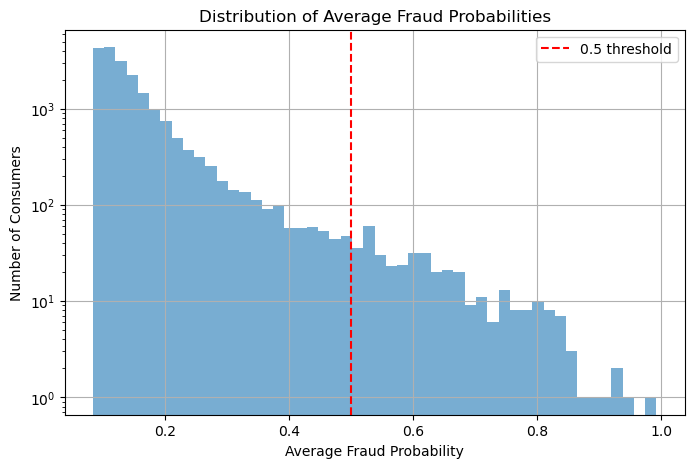

In [15]:
plt.figure(figsize=(8,5))
consumer_features["fraud_prob_avg"].dropna().hist(bins=50, alpha=0.6, log=True)
plt.axvline(0.5, color="red", linestyle="--", label="0.5 threshold")
plt.xlabel("Average Fraud Probability")
plt.ylabel("Number of Consumers")
plt.title("Distribution of Average Fraud Probabilities")
plt.legend()
plt.show()

In [16]:
print("Fraud by gender:")
print(consumer_features.groupby("gender")["fraud_prob_avg"].mean().sort_values(ascending=False))

# by state
print("Top 10 states by fraud probability:")
print(consumer_features.groupby("state")["fraud_prob_avg"].mean().sort_values(ascending=False).head(10))

# by postcode (n >= 50)
fraud_by_postcode = (consumer_features.groupby("postcode")["fraud_prob_avg"]
                     .agg(["count","mean"])
                     .query("count >= 50")
                     .sort_values("mean", ascending=False))
print("Top 10 postcodes (n>=50) by fraud probability:")
print(fraud_by_postcode.head(10))

Fraud by gender:
gender
Undisclosed    0.157945
Male           0.157520
Female         0.155554
Name: fraud_prob_avg, dtype: float64
Top 10 states by fraud probability:
state
TAS    0.159692
QLD    0.158912
NT     0.158546
VIC    0.157258
SA     0.156953
NSW    0.156577
WA     0.153552
ACT    0.146520
Name: fraud_prob_avg, dtype: float64
Top 10 postcodes (n>=50) by fraud probability:
Empty DataFrame
Columns: [count, mean]
Index: []


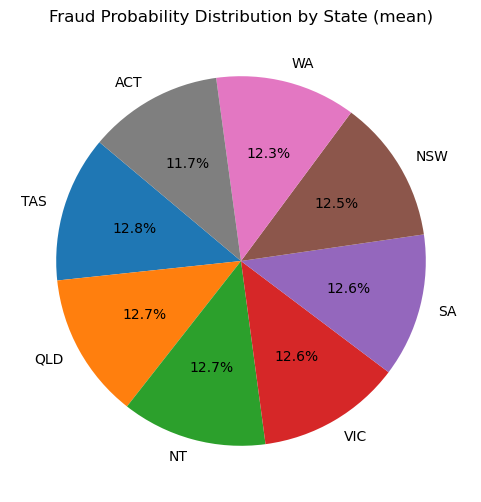

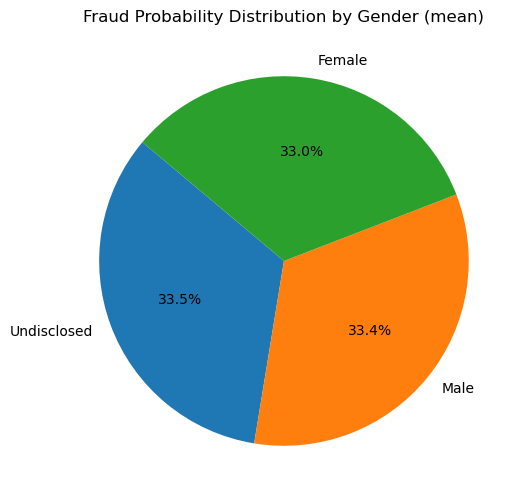

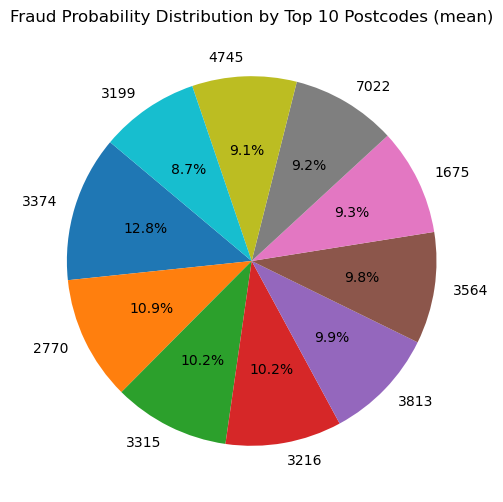

In [17]:
# --- Fraud probability by state ---
fraud_by_state = (consumer_features.groupby("state")["fraud_prob_avg"]
                  .mean().dropna().sort_values(ascending=False))

plt.figure(figsize=(6,6))
plt.pie(
    fraud_by_state.values,
    labels=fraud_by_state.index,
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Fraud Probability Distribution by State (mean)")
plt.show()

# --- Fraud probability by gender ---
fraud_by_gender = (consumer_features.groupby("gender")["fraud_prob_avg"]
                   .mean().dropna().sort_values(ascending=False))

plt.figure(figsize=(6,6))
plt.pie(
    fraud_by_gender.values,
    labels=fraud_by_gender.index,
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Fraud Probability Distribution by Gender (mean)")
plt.show()

# --- Fraud probability by postcode (filter for enough records) ---
fraud_by_postcode = (consumer_features.groupby("postcode")["fraud_prob_avg"]
                     .agg(["mean"])
                     .sort_values("mean", ascending=False)
                    )

# top 10 risky postcodes
top_pc = fraud_by_postcode.head(10)

plt.figure(figsize=(6,6))
plt.pie(
    top_pc["mean"],
    labels=top_pc.index,
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Fraud Probability Distribution by Top 10 Postcodes (mean)")
plt.show()

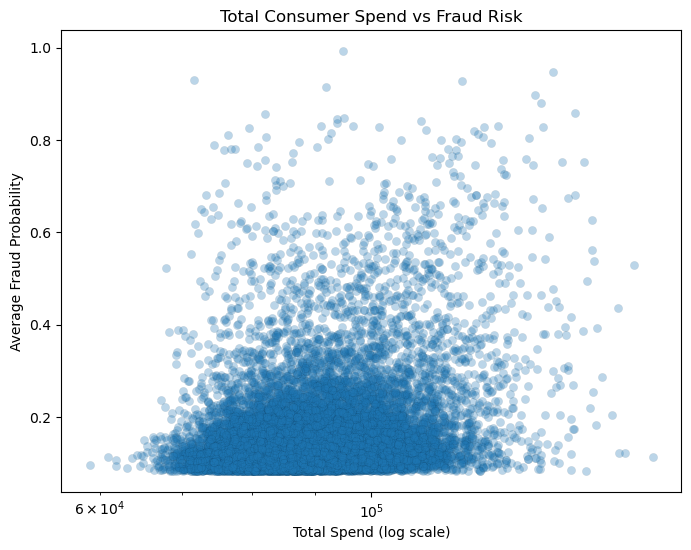

In [18]:
plt.figure(figsize=(8,6))
plt.scatter(consumer_features["total_spend"], consumer_features["fraud_prob_avg"],
            alpha=0.3, edgecolor="k", linewidth=0.1)
plt.xscale("log")
plt.xlabel("Total Spend (log scale)")
plt.ylabel("Average Fraud Probability")
plt.title("Total Consumer Spend vs Fraud Risk")
plt.show()

# Merchant Datasets

### Dataset Shapes

In [19]:
print("merchant_details shape:", merchant_details.shape)   
print("merchant_fraud shape:", merchant_fraud.shape)
print("transactions shape:", transactions.shape)
print("unique merchants in merchant_details:", merchant_details["merchant_abn"].nunique())
print("unique merchants in merchant_fraud:", merchant_fraud["merchant_abn"].nunique())
print("unique merchants in transactions:", transactions["merchant_abn"].nunique())

merchant_details shape: (4026, 6)
merchant_fraud shape: (114, 3)
transactions shape: (13614672, 5)
unique merchants in merchant_details: 4026
unique merchants in merchant_fraud: 61
unique merchants in transactions: 4026


### Merge the merchant data

In [20]:
# Join merchant data
merchant_df = merchant_details.merge(merchant_fraud, on="merchant_abn", how="left")

In [21]:
# Check how many merchants have a fraud probability record
n_total = merchant_df["merchant_abn"].nunique()
n_with_fraud = merchant_df["tx_fraud_merchant"].notna().sum()   # if multiple rows per merchant
n_with_fraud_unique = merchant_df.groupby("merchant_abn")["tx_fraud_merchant"].apply(lambda s: s.notna().any()).sum()

print("Total merchants:", n_total)
print("Merchants with ≥1 fraud probability record:", n_with_fraud_unique)
print("Coverage (%):", round(n_with_fraud_unique / n_total * 100, 2))

Total merchants: 4026
Merchants with ≥1 fraud probability record: 48
Coverage (%): 1.19


In [22]:
merchant_df["tx_fraud_merchant"].describe()

count    95.000000
mean      0.395174
std       0.166174
min       0.182109
25%       0.289727
50%       0.315374
75%       0.442082
max       0.910961
Name: tx_fraud_merchant, dtype: float64

## Merchant Feature Engineering

In [23]:
# Compute order count per merchant = total number of transactions per merchant
order_count = (
    transactions.groupby("merchant_abn")
    .size()  # counts rows per merchant
    .reset_index(name="order_count")
)

# Merge into merchant_features
merchant_features = merchant_details.merge(order_count, on="merchant_abn", how="left")
merchant_features["order_count"] = merchant_features["order_count"].fillna(0)

In [24]:
# Compute total sales per merchant = sum of all transaction dollar values
total_sales = (
    transactions.groupby("merchant_abn")["dollar_value"]
    .sum()
    .reset_index(name="total_sales")
)

# Merge into merchant_features
merchant_features = merchant_features.merge(total_sales, on="merchant_abn", how="left")

In [25]:
# Compute average order value per merchant = total sales / order count
merchant_features["avg_order_value"] = (
    merchant_features["total_sales"] / merchant_features["order_count"]
)

In [26]:
# Count how many purchases each customer made per merchant
customer_orders = (
    transactions.groupby(["merchant_abn", "user_id"])["order_id"]
    .count()
    .reset_index(name="order_count")
)

# For each merchant, count the total unique customers
# and the number of customers with 2+ purchases
repurchase_stats = (
    customer_orders.groupby("merchant_abn")
    .agg(
        unique_consumers=("user_id", "nunique"),
        repeat_consumers=("order_count", lambda x: (x >= 2).sum())
    )
    .reset_index()
)

# Compute repurchase rate
repurchase_stats["repurchase_rate"] = (
    repurchase_stats["repeat_consumers"] / repurchase_stats["unique_consumers"]
)

# Merge into merchant_features
merchant_features = merchant_features.merge(repurchase_stats, on="merchant_abn", how="left")

merchant_features.head(10)

,merchant_abn,name,tags,categories,type,take_rate,order_count,total_sales,avg_order_value,unique_consumers,repeat_consumers,repurchase_rate
0,10023283211,Felis Limited,"((furniture, home furnishings and equipment sh...","[furniture, home furnishings and equipment sho...",e,0.18,3261,7.032777e+05,215.663205,3032,218,0.071900
1,10142254217,Arcu Ac Orci Corporation,"([cable, satellite, and otHer pay television a...","[cable, satellite, and other pay television an...",b,4.22,3036,1.183561e+05,38.984238,2849,182,0.063882
2,10165489824,Nunc Sed Company,"([jewelry, watch, clock, and silverware shops]...","[jewelry, watch, clock, and silverware shops]",b,4.40,5,5.618047e+04,11236.094771,5,0,0.000000
3,10187291046,Ultricies Dignissim Lacus Foundation,"([wAtch, clock, and jewelry repair shops], [b]...","[watch, clock, and jewelry repair shops]",b,3.29,336,3.969373e+04,118.136102,335,1,0.002985
4,10192359162,Enim Condimentum PC,"([music shops - musical instruments, pianos, a...","[music shops - musical instruments, pianos, an...",a,6.33,385,1.779805e+05,462.287027,383,2,0.005222
5,10206519221,Fusce Company,"[(gift, card, novelty, and souvenir shops), (a...","[gift, card, novelty, and souvenir shops]",a,6.34,9621,3.582230e+05,37.233448,7900,1516,0.191899
6,10255988167,Aliquam Enim Incorporated,"[(computers, comPUter peripheral equipment, an...","[computers, computer peripheral equipment, and...",b,4.32,832,3.224741e+05,387.589082,816,16,0.019608
7,10264435225,Ipsum Primis Ltd,"[[watch, clock, and jewelry repair shops], [c]...","[watch, clock, and jewelry repair shops]",c,2.39,5026,5.872259e+05,116.837631,4535,461,0.101654
8,10279061213,Pede Ultrices Industries,"([computer programming , data processing, and ...","[computer programming, data processing, and in...",a,5.71,555,1.660582e+05,299.203949,549,5,0.009107
9,10323485998,Nunc Inc.,"[(furniture, home furnishings and equipment sh...","[furniture, home furnishings and equipment sho...",a,6.61,10335,1.327030e+06,128.401574,8405,1667,0.198334


In [27]:
merchant_features.shape

(4026, 12)

In [28]:
# count NaN values per column
nan_counts = merchant_features.isna().sum()
nan_counts

merchant_abn        0
name                0
tags                0
categories          0
type                0
take_rate           0
order_count         0
total_sales         0
avg_order_value     0
unique_consumers    0
repeat_consumers    0
repurchase_rate     0
dtype: int64

In [29]:
# Save to curated folder
merchant_features.to_parquet(CUR / "merchant_features.parquet", index=False)

## EDA for Merchant Dataset

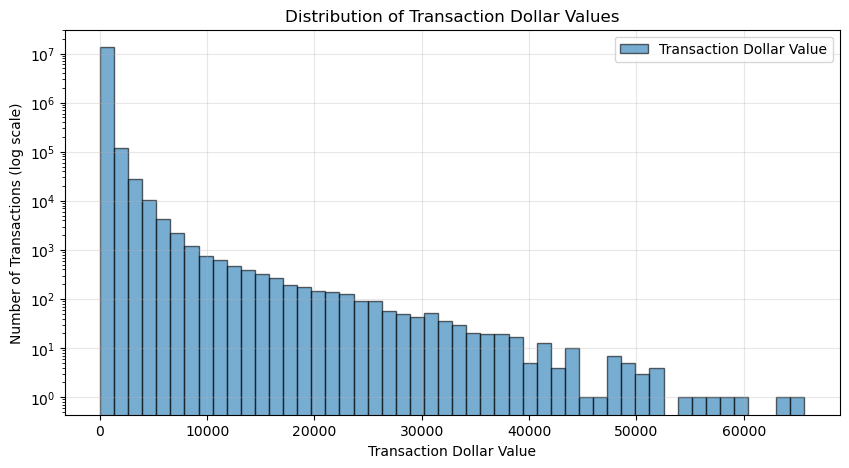

In [30]:
# Transaction value distribution
# Plot
plt.figure(figsize=(10,5))

# Apply log-scale to y axis as distribution is highly skewed
plt.hist(transactions["dollar_value"].dropna(), bins=50, alpha=0.6, label="Transaction Dollar Value", log=True, edgecolor="black")
plt.xlabel("Transaction Dollar Value")
plt.ylabel("Number of Transactions (log scale)")
plt.title("Distribution of Transaction Dollar Values")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

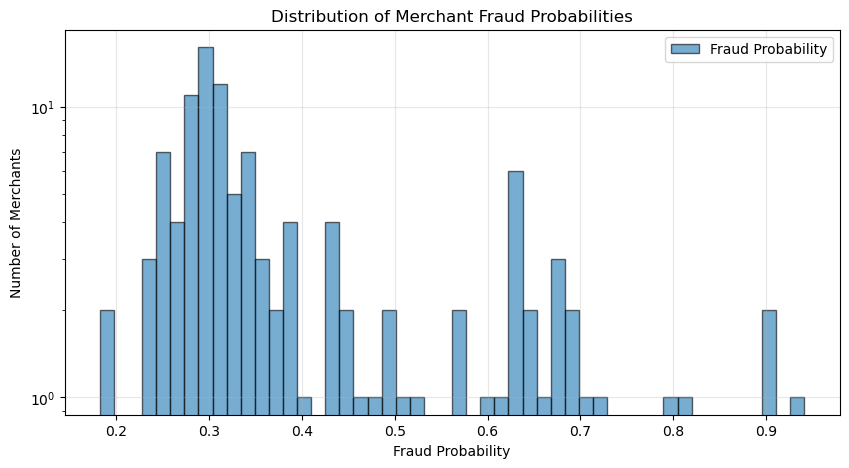

In [31]:
# Merchant fraud distribution
# Plot
plt.figure(figsize=(10,5))

# Apply log-scale to y axis as distribution is highly skewed
plt.hist(merchant_fraud["tx_fraud_merchant"].dropna(), bins=50, alpha=0.6, label="Fraud Probability", log=True, edgecolor="black")
plt.xlabel("Fraud Probability")
plt.ylabel("Number of Merchants")
plt.title("Distribution of Merchant Fraud Probabilities")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

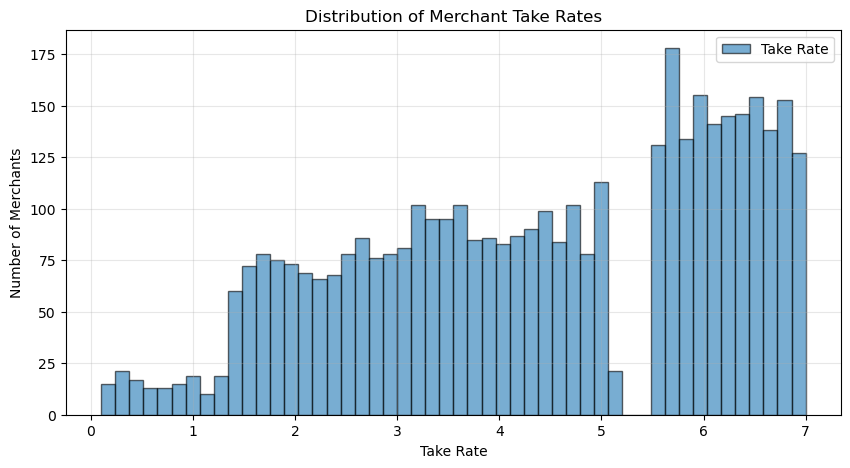

In [32]:
# Take rate distribution
# Plot
plt.figure(figsize=(10,5))

plt.hist(merchant_features["take_rate"].dropna(), bins=50, alpha=0.6, label="Take Rate", edgecolor="black")

plt.xlabel("Take Rate")
plt.ylabel("Number of Merchants")
plt.title("Distribution of Merchant Take Rates")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

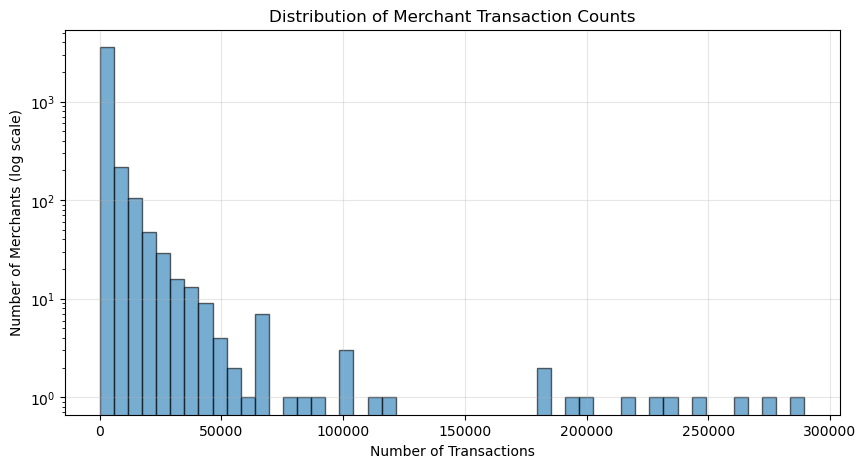

In [33]:
plt.figure(figsize=(10,5))
plt.hist(merchant_features["order_count"], bins=50, log=True, alpha=0.6, edgecolor="black")
plt.xlabel("Number of Transactions")
plt.ylabel("Number of Merchants (log scale)")
plt.title("Distribution of Merchant Transaction Counts")
plt.grid(True, alpha=0.3)
plt.show()

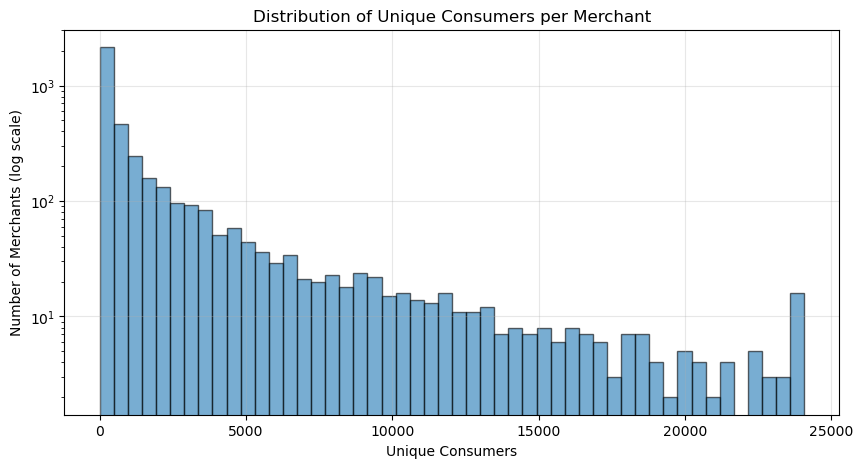

In [34]:
# Plot distribution of unique consumers per merchant
plt.figure(figsize=(10,5))

plt.hist(merchant_features["unique_consumers"].dropna(),
         bins=50, alpha=0.6, edgecolor="black", log=True)

plt.xlabel("Unique Consumers")
plt.ylabel("Number of Merchants (log scale)")
plt.title("Distribution of Unique Consumers per Merchant")
plt.grid(True, alpha=0.3)
plt.show()

<Figure size 1000x600 with 0 Axes>

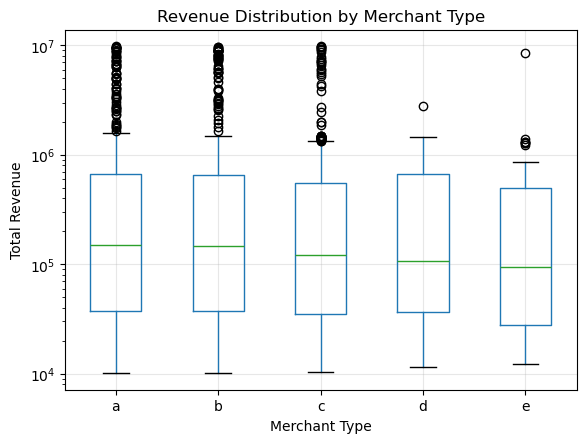

In [35]:
# Total Revenue by Merchant Type (Boxplot)
plt.figure(figsize=(10,6))

merchant_features.boxplot(column="total_sales", by="type")

# Apply log-scale to y axis if needed (depends on skew, but try normal first)
plt.yscale("log")
plt.xlabel("Merchant Type")
plt.ylabel("Total Revenue")
plt.title("Revenue Distribution by Merchant Type")
plt.suptitle("") 
plt.grid(True, alpha=0.3)
plt.show()

<Figure size 1000x600 with 0 Axes>

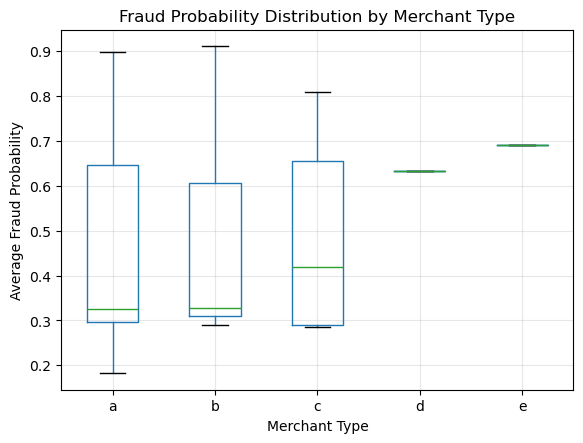

In [36]:
# Compute average fraud probability per merchant
merchant_fraud_avg = (
    merchant_fraud.groupby("merchant_abn")["tx_fraud_merchant"]
    .mean()
    .reset_index(name="avg_fraud_probability")
)

# Merge with merchant_features to get type info
fraud_with_type = merchant_features.merge(merchant_fraud_avg, on="merchant_abn", how="left")

# Fraud Probability by Merchant Type (Boxplot)
plt.figure(figsize=(10,6))

fraud_with_type.boxplot(column="avg_fraud_probability", by="type")

plt.xlabel("Merchant Type")
plt.ylabel("Average Fraud Probability")
plt.title("Fraud Probability Distribution by Merchant Type")
plt.suptitle("")  # remove auto subtitle
plt.grid(True, alpha=0.3)
plt.show()

# Summary from the Preliminary Analysis

**consumer_features:**

- **consumer_id** → unique identifier for the consumer  
- **transaction_count** → total number of transactions made  
- **total_spend** → total dollar value spent across all transactions  
- **unique_merchants** → number of distinct merchants purchased from  
- **avg_spend** → average spend per transaction  
- **fraud_prob_avg** → average fraud probability across transactions
- **name** → consumer’s name  
- **address** → consumer’s address  
- **state** → state of residence  
- **postcode** → postcode of residence  
- **gender** → gender of the consumer  
- **user_id** → unique user identifier linked to transactions 

**merchant_features:**  

- **merchant_abn** → unique identifier for the merchant  
- **name** → merchant’s name  
- **tags** → descriptive tags associated with the merchant  
- **categories** → category labels for the merchant  
- **type** → merchant type classification  
- **take_rate** → BNPL commission rate (%)  
- **order_count** → total number of transactions with this merchant   
- **total_sales** → total revenue generated from transactions  
- **avg_order_value** → average value per transaction    
- **unique_consumers** → number of distinct customers served  
- **repeat_consumers** → number of customers with 2+ purchases  
- **repurchase_rate** → proportion of customers who are repeat buyers 